# Progetto Machine Learning: Riconoscimento di Specie di Uccelli con CNN

Questo notebook implementa un sistema di riconoscimento di specie di uccelli attraverso l'analisi di registrazioni audio della competizione BirdClef 2025. Il progetto utilizza un'architettura CNN per classificare gli audio convertiti in spettrogrammi Mel e include anche un sistema di configurazione automatica dell'ambiente per eseguire il codice su Kaggle, Google Colab o in locale.

## 1. Importazione delle Librerie Necessarie

Importiamo tutte le librerie necessarie per l'elaborazione audio, deep learning e visualizzazione.

In [1]:
# Librerie di sistema e utilità
import os
import sys
import platform
import time
import warnings
import logging
import datetime
from pathlib import Path
import pprint as pp
import seaborn as sns
from collections import Counter
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Librerie per data science e manipolazione dati
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Librerie per elaborazione audio
import librosa
import librosa.display

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualizzazione
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Ignoriamo i warning
warnings.filterwarnings("ignore")

# Configurazione del logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('BirdClef')

print("Librerie importate con successo!")
print(f"PyTorch versione: {torch.__version__}")
print(f"Python versione: {platform.python_version()}")
print(f"Sistema operativo: {platform.system()} {platform.release()}")

Librerie importate con successo!
PyTorch versione: 2.5.1+cu124
Python versione: 3.11.11
Sistema operativo: Linux 6.6.56+


## 2. Configurazione dell'Ambiente di Esecuzione

In questa sezione configuriamo l'ambiente di esecuzione in modo che il notebook funzioni sia su Kaggle, che su Google Colab, che in locale. Il codice rileverà automaticamente l'ambiente e configurerà i percorsi di conseguenza.

In [2]:
# Variabile per impostare manualmente l'ambiente
# Modifica questa variabile in base all'ambiente in uso:
# - 'kaggle' per l'ambiente Kaggle
# - 'colab' per Google Colab
# - 'local' per l'esecuzione in locale
MANUAL_ENVIRONMENT = ''  # Impostare su 'kaggle', 'colab', o 'local' per forzare l'ambiente

def detect_environment():
    """
    Rileva se il notebook è in esecuzione su Kaggle, Google Colab o in locale.
    Rispetta l'impostazione manuale se fornita.
    
    Returns:
        str: 'kaggle', 'colab', o 'local'
    """
    # Se l'ambiente è stato impostato manualmente, usa quello
    if MANUAL_ENVIRONMENT in ['kaggle', 'colab', 'local']:
        print(f"Utilizzo ambiente impostato manualmente: {MANUAL_ENVIRONMENT}")
        return MANUAL_ENVIRONMENT
    
    # Verifica Kaggle con metodo più affidabile
    # Verifica l'esistenza di directory specifiche di Kaggle
    if os.path.exists('/kaggle/working') and os.path.exists('/kaggle/input'):
        print("Rilevato ambiente Kaggle")
        return 'kaggle'
    
    # Verifica se è Google Colab
    try:
        import google.colab
        return 'colab'
    except ImportError:
        pass
    
    # Se non è né Kaggle né Colab, allora è locale
    return 'local'

# Rileva l'ambiente attuale
ENVIRONMENT = detect_environment()
print(f"Ambiente rilevato: {ENVIRONMENT}")

Rilevato ambiente Kaggle
Ambiente rilevato: kaggle


In [3]:
class Config:
    def __init__(self):
        # Rileva l'ambiente
        self.environment = ENVIRONMENT  # Usa la variabile globale impostata in precedenza
        
        # Imposta i percorsi di base in base all'ambiente
        if self.environment == 'kaggle':
            self.COMPETITION_NAME = "birdclef-2025"
            self.BASE_DIR = f"/kaggle/input/{self.COMPETITION_NAME}"
            self.OUTPUT_DIR = "/kaggle/working"
            self.MODELS_DIR = "/kaggle/input"  # Per i modelli pre-addestrati
            
            # Imposta subito i percorsi derivati per l'ambiente Kaggle
            self._setup_derived_paths()
            
        elif self.environment == 'colab':
            # In Colab, inizializza directory base temporanee
            self.COMPETITION_NAME = "birdclef-2025"
            self.OUTPUT_DIR = "/content/output"
            self.MODELS_DIR = "/content/models"
            
            # Crea le directory di output
            os.makedirs(self.OUTPUT_DIR, exist_ok=True)
            os.makedirs(self.MODELS_DIR, exist_ok=True)
            
            # In Colab, BASE_DIR verrà impostato dopo il download
            # quindi non impostiamo ancora i percorsi derivati
            self.BASE_DIR = "/content/placeholder"  # Verrà sovrascritto dopo il download
            
            # Inizializza i percorsi dei file a None per ora
            self.TRAIN_AUDIO_DIR = None
            self.TEST_SOUNDSCAPES_DIR = None
            self.TRAIN_CSV_PATH = None
            self.TAXONOMY_CSV_PATH = None
            self.SAMPLE_SUB_PATH = None
            
        else:  # locale
            # In ambiente locale, i percorsi dipenderanno dalla tua configurazione
            self.BASE_DIR = os.path.abspath(".")
            self.OUTPUT_DIR = os.path.join(self.BASE_DIR, "output")
            self.MODELS_DIR = os.path.join(self.BASE_DIR, "models")
            
            # Crea le directory se non esistono
            os.makedirs(self.OUTPUT_DIR, exist_ok=True)
            os.makedirs(self.MODELS_DIR, exist_ok=True)
            
            # Imposta i percorsi derivati
            self._setup_derived_paths()
        
        # Parametri per il preprocessing audio
        self.SR = 32000  # Sample rate
        self.DURATION = 5  # Durata dei clip in secondi
        self.N_MELS = 128  # Numero di bande Mel
        self.N_FFT = 2048  # Dimensione finestra FFT
        self.HOP_LENGTH = 512  # Hop length per STFT
        self.FMIN = 0  # Frequenza minima per lo spettrogramma Mel
        self.FMAX = self.SR / 2  # Frequenza massima
        
        # Parametri per il training
        self.BATCH_SIZE = 32
        self.EPOCHS = 10
        self.LEARNING_RATE = 1e-3
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.NUM_WORKERS = 0  # Numero di worker per il DataLoader

        # Parametri per inference/submission
        self.TEST_CLIP_DURATION = 5  # Durata dei segmenti per la predizione (secondi)
        self.N_CLASSES = 0  # Sarà impostato dopo aver caricato i dati

    def _setup_derived_paths(self):
        """Imposta i percorsi derivati basati su BASE_DIR"""
        # Utilizza la normale divisione di percorso di OS (non il backslash hardcoded)
        self.TRAIN_AUDIO_DIR = os.path.join(self.BASE_DIR, "train_audio")
        self.TEST_SOUNDSCAPES_DIR = os.path.join(self.BASE_DIR, "test_soundscapes")
        self.TRAIN_CSV_PATH = os.path.join(self.BASE_DIR, "train.csv")
        self.TAXONOMY_CSV_PATH = os.path.join(self.BASE_DIR, "taxonomy.csv") 
        self.SAMPLE_SUB_PATH = os.path.join(self.BASE_DIR, "sample_submission.csv")

In [4]:
config = Config()

# Gestione download dati in Colab con kagglehub
if config.environment == 'colab':
    # Percorsi nella cache di kagglehub
    cache_competition_path = "/root/.cache/kagglehub/competitions/birdclef-2025"
    cache_model_path = "/root/.cache/kagglehub/models/maurocarlu/simplecnn/PyTorch/default/1"
    cache_model_file = os.path.join(cache_model_path, "baseline_bird_cnn_model_val.pth")
    
    # Verifica se i dati sono già presenti nella cache
    data_exists = os.path.exists(os.path.join(cache_competition_path, "train.csv"))
    model_exists = os.path.exists(cache_model_file)
    
    if data_exists and model_exists:
        print("I dati e il modello sono già presenti nella cache. Utilizzo copie esistenti.")
        birdclef_path = cache_competition_path
        model_path = cache_model_path
    else:
        print("Scaricamento dati con kagglehub...")
        
        try:
            import kagglehub
            
            # Scarica solo i dati della competizione se necessario
            if not data_exists:
                print("Download dataset...")
                kagglehub.login()  # Mostra dialog di login interattivo
                birdclef_path = kagglehub.competition_download('birdclef-2025')
            else:
                print("Dataset già presente nella cache.")
                birdclef_path = cache_competition_path
                
            # Scarica solo il modello se necessario
            if not model_exists:
                print("Download modello...")
                kagglehub.login()  # Potrebbe essere necessario riautenticarsi
                model_path = kagglehub.model_download('maurocarlu/simplecnn/PyTorch/default/1')
            else:
                print("Modello già presente nella cache.")
                model_path = cache_model_path
                
            print(f"Download completato.")
            
        except Exception as e:
            print(f"Errore durante il download dei dati: {e}")
            print("Prova ad usare Google Drive o esegui su Kaggle.")
            
            # Se il download fallisce ma i dati esistono parzialmente, usa quelli
            if os.path.exists(cache_competition_path):
                birdclef_path = cache_competition_path
                print(f"Usando i dati esistenti in: {birdclef_path}")
            if os.path.exists(cache_model_path):
                model_path = cache_model_path
                print(f"Usando il modello esistente in: {model_path}")
    
    # Aggiorna i percorsi nella configurazione
    config.BASE_DIR = birdclef_path
    config._setup_derived_paths()
    config.MODELS_DIR = model_path
    model_file = os.path.join(model_path, "baseline_bird_cnn_model_val.pth")
    
    print(f"Dati disponibili in: {config.BASE_DIR}")
    print(f"Modello disponibile in: {model_file}")

# Stampa percorsi aggiornati
print(f"\nPercorso file CSV di training: {config.TRAIN_CSV_PATH}")
print(f"Percorso directory audio di training: {config.TRAIN_AUDIO_DIR}")


Percorso file CSV di training: /kaggle/input/birdclef-2025/train.csv
Percorso directory audio di training: /kaggle/input/birdclef-2025/train_audio


## 3. Configurazione del Modello e Parametri

Definiamo i parametri di configurazione per il preprocessamento audio, la creazione dello spettrogramma Mel e l'addestramento della CNN.

In [5]:
# I parametri principali sono già definiti nella classe Config
# Verifichiamo l'esistenza delle directory e creiamo quelle necessarie per l'output

def setup_output_directories():
    """
    Configura le directory per l'output del progetto.
    
    Returns:
        dict: Dictionary con i percorsi delle directory di output
    """
    # Directory principale di output
    output_dir = config.OUTPUT_DIR
    
    # Sotto-directory per diversi tipi di output
    dirs = {
        'checkpoints': os.path.join(output_dir, 'checkpoints'),
        'tensorboard': os.path.join(output_dir, 'tensorboard_logs'),
        'predictions': os.path.join(output_dir, 'predictions'),
        'submissions': os.path.join(output_dir, 'submissions'),
        'visualizations': os.path.join(output_dir, 'visualizations'),
    }
    
    # Crea tutte le directory
    for dir_name, dir_path in dirs.items():
        os.makedirs(dir_path, exist_ok=True)
        print(f"Directory '{dir_name}' creata/verificata in: {dir_path}")
    
    return dirs

# Configura le directory di output
output_dirs = setup_output_directories()

# Crea un file di log per tenere traccia dei risultati
log_file_path = os.path.join(config.OUTPUT_DIR, f"experiment_log_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

with open(log_file_path, 'w') as log_file:
    log_file.write(f"=== BirdClef Experiment Log ===\n")
    log_file.write(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    log_file.write(f"Environment: {config.environment}\n\n")
    log_file.write("Output directories:\n")
    for dir_name, dir_path in output_dirs.items():
        log_file.write(f"- {dir_name}: {dir_path}\n")

print(f"File di log creato in: {log_file_path}")

# Memorizziamo i parametri di configurazione principali per l'addestramento
print("\nParametri di configurazione principali:")
print(f"- Sample rate: {config.SR} Hz")
print(f"- Durata clip audio: {config.DURATION} secondi")
print(f"- Numero bande Mel: {config.N_MELS}")
print(f"- Dimensione FFT: {config.N_FFT}")
print(f"- Hop length: {config.HOP_LENGTH}")
print(f"- Device: {config.DEVICE}")
print(f"- Batch size: {config.BATCH_SIZE}")
print(f"- Epoche: {config.EPOCHS}")
print(f"- Learning rate: {config.LEARNING_RATE}")

Directory 'checkpoints' creata/verificata in: /kaggle/working/checkpoints
Directory 'tensorboard' creata/verificata in: /kaggle/working/tensorboard_logs
Directory 'predictions' creata/verificata in: /kaggle/working/predictions
Directory 'submissions' creata/verificata in: /kaggle/working/submissions
Directory 'visualizations' creata/verificata in: /kaggle/working/visualizations
File di log creato in: /kaggle/working/experiment_log_20250514_174006.txt

Parametri di configurazione principali:
- Sample rate: 32000 Hz
- Durata clip audio: 5 secondi
- Numero bande Mel: 128
- Dimensione FFT: 2048
- Hop length: 512
- Device: cpu
- Batch size: 32
- Epoche: 10
- Learning rate: 0.001


## 4. Caricamento e Preprocessing dei Dati

In questa sezione carichiamo i metadati dal file CSV di training, creiamo codifiche one-hot per le etichette delle specie e implementiamo funzioni per il caricamento e preprocessamento dei file audio.

In [6]:
# Caricamento dei metadati
def load_metadata():
    """
    Carica e prepara i metadati dal file CSV di training.
    
    Returns:
        tuple: training_df, all_species, labels_one_hot
    """
    print(f"Caricamento metadati da: {config.TRAIN_CSV_PATH}")
    train_df = pd.read_csv(config.TRAIN_CSV_PATH)
    taxonomy_df = pd.read_csv(config.TAXONOMY_CSV_PATH)
    sample_sub_df = pd.read_csv(config.SAMPLE_SUB_PATH)
    
    # Estrai tutte le etichette uniche
    train_primary_labels = train_df['primary_label'].unique()
    train_secondary_labels = set([lbl for sublist in train_df['secondary_labels'].apply(eval) 
                                 for lbl in sublist if lbl])
    submission_species = sample_sub_df.columns[1:].tolist()  # Escludi row_id
    
    # Combina tutte le possibili etichette
    all_species = sorted(list(set(train_primary_labels) | train_secondary_labels | set(submission_species)))
    N_CLASSES = len(all_species)
    config.N_CLASSES = N_CLASSES  # Aggiorna il numero di classi nella configurazione
    
    print(f"Numero totale di specie trovate: {N_CLASSES}")
    print(f"Prime 10 specie: {all_species[:10]}")
    
    # Crea mappatura etichette-indici
    species_to_int = {species: i for i, species in enumerate(all_species)}
    int_to_species = {i: species for species, i in species_to_int.items()}
    
    # Aggiungi indici numerici al dataframe
    train_df['primary_label_int'] = train_df['primary_label'].map(species_to_int)
    
    # Prepara target multi-etichetta
    mlb = MultiLabelBinarizer(classes=all_species)
    mlb.fit(None)  # Fit con tutte le classi
    
    def get_multilabel(row):
        labels = eval(row['secondary_labels'])  # Valuta la lista di stringhe in modo sicuro
        labels.append(row['primary_label'])
        return list(set(labels))  # Assicura etichette uniche
    
    train_df['all_labels'] = train_df.apply(get_multilabel, axis=1)
    train_labels_one_hot = mlb.transform(train_df['all_labels'])
    
    print(f"Forma delle etichette one-hot: {train_labels_one_hot.shape}")
    
    return train_df, all_species, train_labels_one_hot, species_to_int, int_to_species

# Carica i metadati
train_df, all_species, train_labels_one_hot, species_to_int, int_to_species = load_metadata()

# Suddividi i dati in training e validation
def split_data(train_df, labels_one_hot, test_size=0.2, random_state=42):
    """
    Suddivide il dataset in set di training e validation.
    
    Args:
        train_df: DataFrame con i metadati
        labels_one_hot: Array di etichette one-hot
        test_size: Percentuale dei dati da usare per validation
        random_state: Seed per riproducibilità
        
    Returns:
        tuple: X_train_df, X_val_df, y_train_one_hot, y_val_one_hot
    """
    # Indici per lo split
    train_indices, val_indices = train_test_split(
        range(len(train_df)),
        test_size=test_size,
        random_state=random_state
    )
    
    # Crea i dataframe e gli array di etichette splittati
    X_train_df = train_df.iloc[train_indices].reset_index(drop=True)
    X_val_df = train_df.iloc[val_indices].reset_index(drop=True)
    
    y_train_one_hot = labels_one_hot[train_indices]
    y_val_one_hot = labels_one_hot[val_indices]
    
    print(f"Dimensioni Training Set: {X_train_df.shape}, Etichette: {y_train_one_hot.shape}")
    print(f"Dimensioni Validation Set: {X_val_df.shape}, Etichette: {y_val_one_hot.shape}")
    
    return X_train_df, X_val_df, y_train_one_hot, y_val_one_hot

# Suddividi i dati in training e validation
X_train_df, X_val_df, y_train_one_hot, y_val_one_hot = split_data(train_df, train_labels_one_hot)

# Crea un test set solo se NON siamo su Kaggle
if config.environment != 'kaggle':
    # Crea un subset per il testing dai dati di validation
    test_size = 0.1  # Percentuale di dati di validation da usare come test
    test_indices, _ = train_test_split(range(len(X_val_df)), test_size=test_size, random_state=42)
    X_test_df = X_val_df.iloc[test_indices].reset_index(drop=True)
    y_test_one_hot = y_val_one_hot[test_indices]
    print(f"Dimensioni Test Set (creato da validation): {X_test_df.shape}, Etichette: {y_test_one_hot.shape}")
    
else:
    print("Ambiente Kaggle rilevato: utilizzerò direttamente i dati di test dalla cartella test_soundscapes")
    
    # Per Kaggle, dovremo creare un dataset speciale per le soundscapes di test
    # Questo verrà utilizzato direttamente nella fase di generazione della submission
    # Non creiamo X_test_df e test_dataset per ora
    X_test_df = None
    y_test_one_hot = None

Caricamento metadati da: /kaggle/input/birdclef-2025/train.csv
Numero totale di specie trovate: 206
Prime 10 specie: ['1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122']
Forma delle etichette one-hot: (28564, 206)
Dimensioni Training Set: (22851, 15), Etichette: (22851, 206)
Dimensioni Validation Set: (5713, 15), Etichette: (5713, 206)
Ambiente Kaggle rilevato: utilizzerò direttamente i dati di test dalla cartella test_soundscapes


## 4.5 Analisi Esplorativa dei Dati (EDA)

In questa sezione esploreremo le caratteristiche del dataset per comprendere meglio la distribuzione delle specie, le proprietà audio e identificare eventuali pattern nei dati.

=== Statistiche di base del dataset ===
Numero totale di registrazioni: 28564
Numero di specie uniche nel dataset: 206
Campi disponibili nei metadati: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'primary_label_int', 'all_labels']

=== Valori mancanti ===
latitude     809
longitude    809
dtype: int64

=== Analisi delle Specie ===
Top 10 specie più frequenti:
primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
Name: count, dtype: int64

Specie meno frequenti (bottom 10):
primary_label
21038      2
41778      2
21116      2
64862      2
528041     2
476537     2
47067      2
42113      2
42087      2
1139490    2
Name: count, dtype: int64


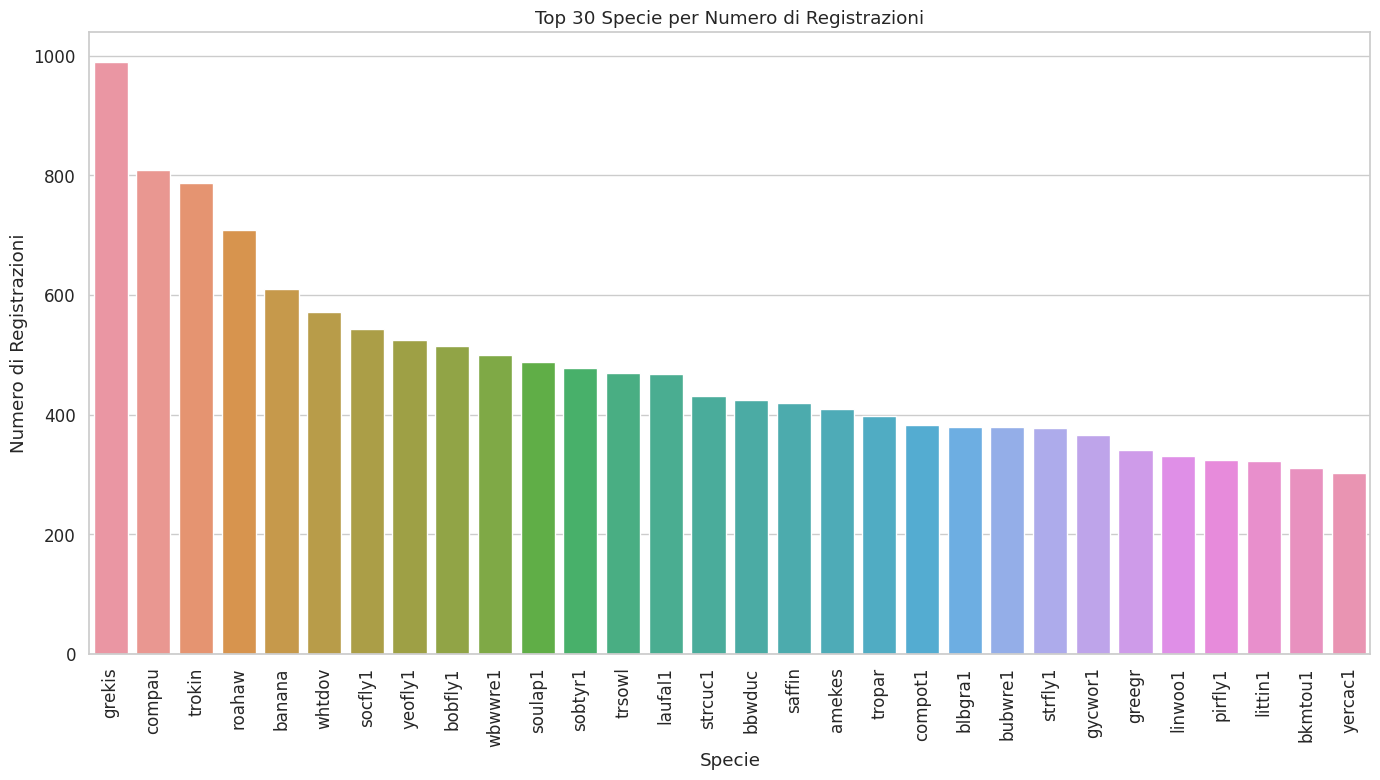


=== Analisi delle Etichette Secondarie ===
Numero di registrazioni con etichette secondarie: 28539
Numero medio di etichette secondarie per registrazione: 0.14


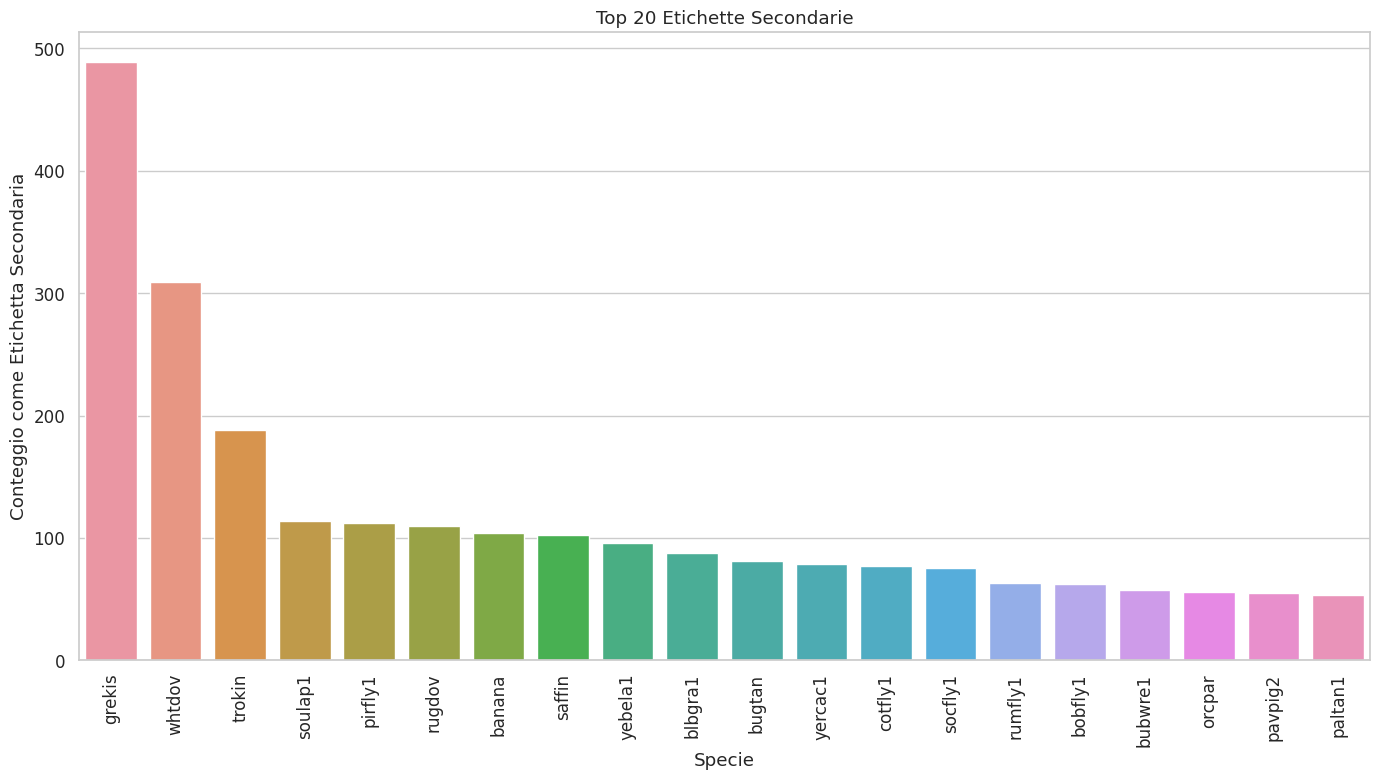


=== Relazione tra Etichette Primarie e Secondarie ===
Top 10 specie che appaiono più frequentemente come secondarie rispetto a primarie:
         primary_count  secondary_count  ratio_secondary_to_primary
rugdov             138              110                    0.797101
whtdov             572              309                    0.540210
crbtan1             56               30                    0.535714
grekis             990              489                    0.493939
recwoo1             90               44                    0.488889
pavpig2            151               55                    0.364238
yebela1            267               96                    0.359551
pirfly1            324              112                    0.345679
yectyr1             97               32                    0.329897
neocor              90               29                    0.322222

=== Analisi delle Proprietà Audio ===
Statistiche delle proprietà audio per alcune specie:
          duration  me

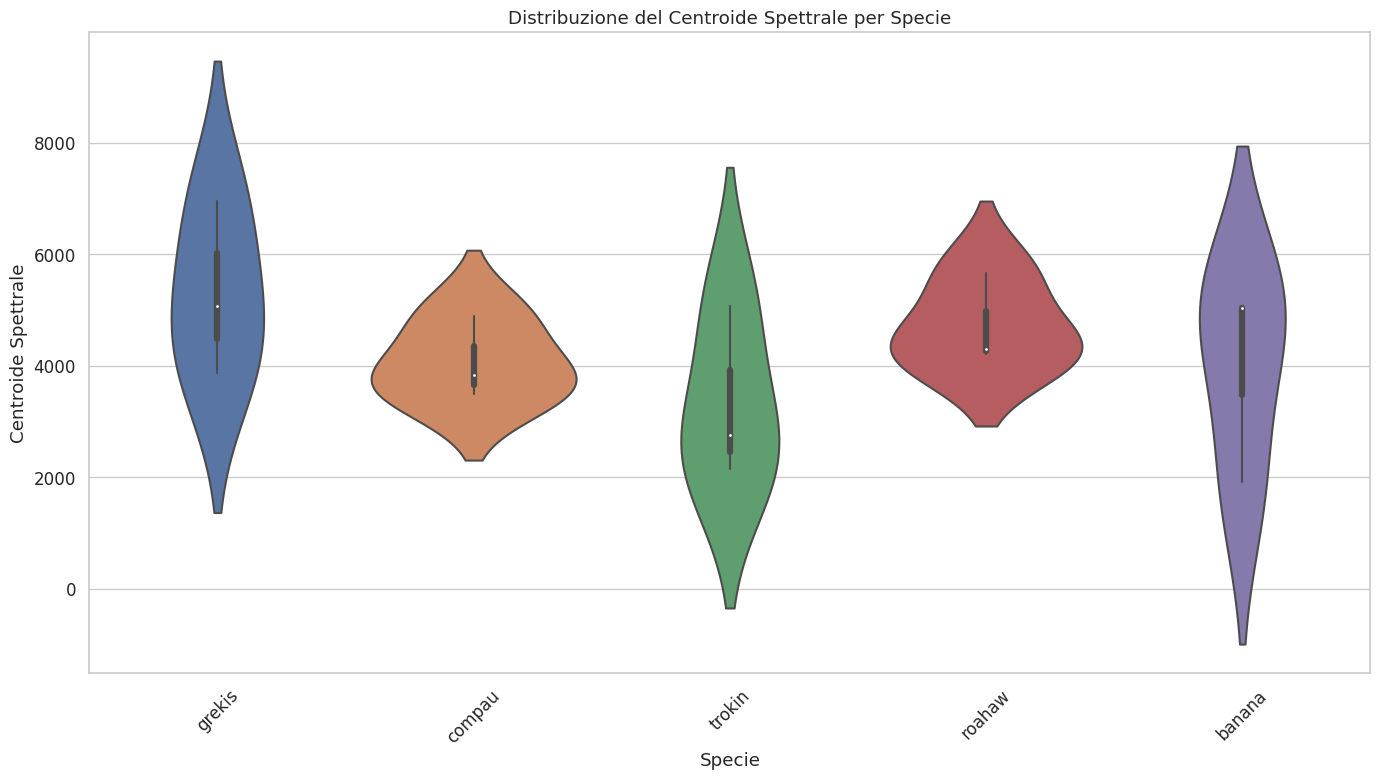

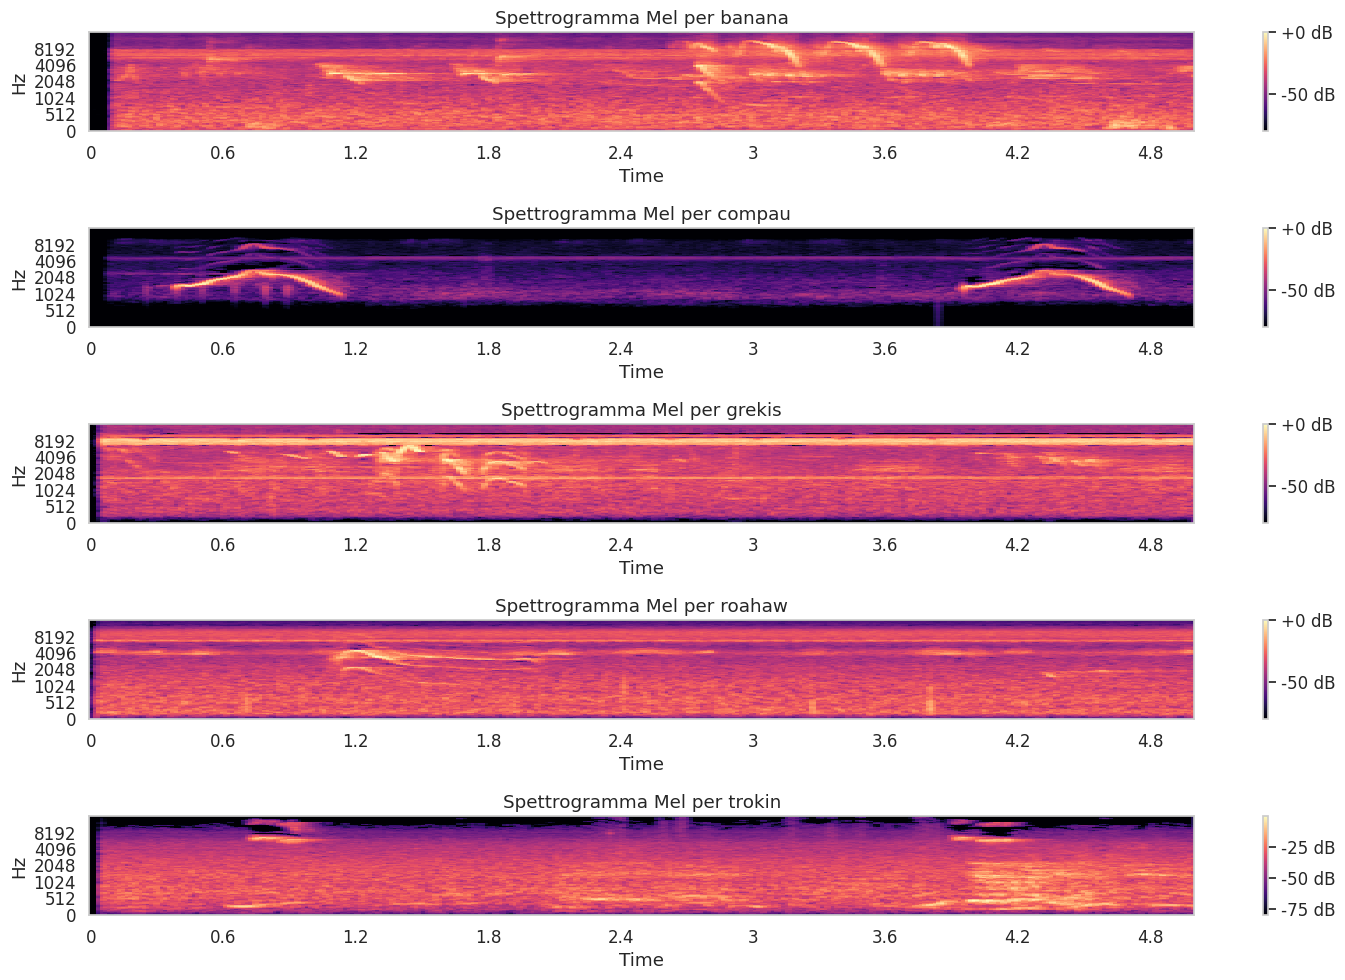

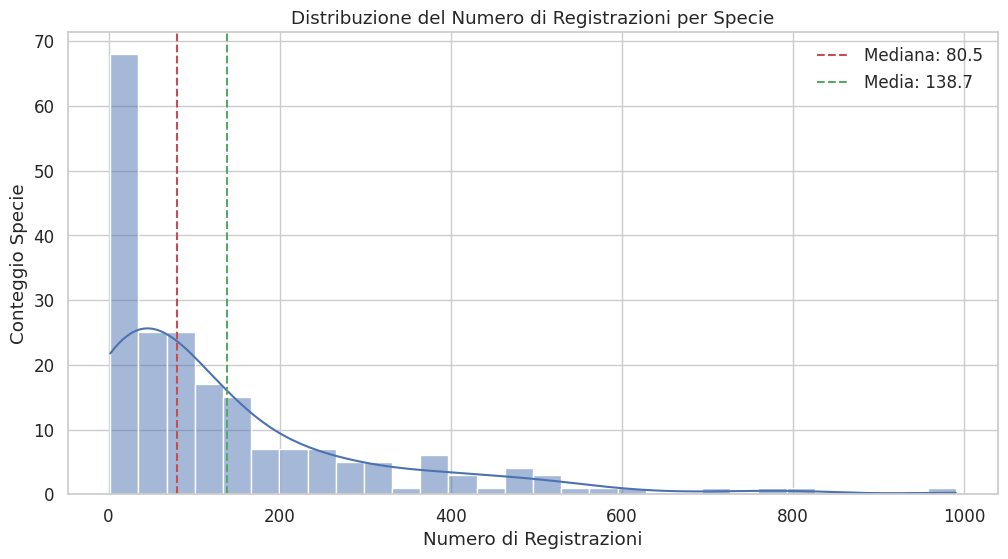


Indice di Gini per la distribuzione delle specie: 0.5895
Questo indica un moderato livello di sbilanciamento nel dataset.

Considerazioni finali dall'analisi esplorativa dei dati:
1. Le specie sono distribuite in modo non uniforme, alcune hanno molte più registrazioni di altre.
2. Ci sono specie che appaiono più frequentemente come etichette secondarie che primarie.
3. Lo sbilanciamento del dataset (indice di Gini: 0.5895) potrebbe richiedere tecniche come oversampling/undersampling o pesi delle classi durante l'addestramento.


In [7]:
# Configurazione stile visualizzazioni
plt.style.use('seaborn-whitegrid')
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = [12, 8]

print("=== Statistiche di base del dataset ===")
print(f"Numero totale di registrazioni: {len(train_df)}")
print(f"Numero di specie uniche nel dataset: {len(all_species)}")
print(f"Campi disponibili nei metadati: {train_df.columns.tolist()}")

# Verifichiamo i dati mancanti
missing_data = train_df.isnull().sum()
print("\n=== Valori mancanti ===")
print(missing_data[missing_data > 0])

# 1. Distribuzione delle specie nel dataset
print("\n=== Analisi delle Specie ===")
primary_species_count = train_df['primary_label'].value_counts()
print(f"Top 10 specie più frequenti:")
print(primary_species_count.head(10))

print(f"\nSpecie meno frequenti (bottom 10):")
print(primary_species_count.tail(10))

# Visualizzazione della distribuzione delle specie
plt.figure(figsize=(14, 8))
sns.barplot(x=primary_species_count.head(30).index, y=primary_species_count.head(30).values)
plt.title('Top 30 Specie per Numero di Registrazioni')
plt.xlabel('Specie')
plt.ylabel('Numero di Registrazioni')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Analisi delle etichette secondarie
secondary_labels_flat = [label for sublist in train_df['secondary_labels'].apply(eval) for label in sublist if label]
secondary_species_count = Counter(secondary_labels_flat)

print("\n=== Analisi delle Etichette Secondarie ===")
print(f"Numero di registrazioni con etichette secondarie: {len([x for x in train_df['secondary_labels'] if len(eval(x)) > 0])}")
print(f"Numero medio di etichette secondarie per registrazione: {len(secondary_labels_flat) / len(train_df):.2f}")

if secondary_labels_flat:
    plt.figure(figsize=(14, 8))
    top_secondary = dict(Counter(secondary_labels_flat).most_common(20))
    sns.barplot(x=list(top_secondary.keys()), y=list(top_secondary.values()))
    plt.title('Top 20 Etichette Secondarie')
    plt.xlabel('Specie')
    plt.ylabel('Conteggio come Etichetta Secondaria')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# 3. Analisi di correlazione tra etichette primarie e secondarie
correlation_df = pd.DataFrame(0, index=all_species, columns=['primary_count', 'secondary_count', 'total_count'])

# Conteggio per etichette primarie
for species in primary_species_count.index:
    correlation_df.loc[species, 'primary_count'] = primary_species_count[species]

# Conteggio per etichette secondarie
for species, count in secondary_species_count.items():
    if species in correlation_df.index:
        correlation_df.loc[species, 'secondary_count'] = count

# Calcolo totale
correlation_df['total_count'] = correlation_df['primary_count'] + correlation_df['secondary_count']
correlation_df['ratio_secondary_to_primary'] = correlation_df['secondary_count'] / correlation_df['primary_count'].replace(0, np.nan)

print("\n=== Relazione tra Etichette Primarie e Secondarie ===")
print("Top 10 specie che appaiono più frequentemente come secondarie rispetto a primarie:")
top_ratio = correlation_df.sort_values('ratio_secondary_to_primary', ascending=False).head(10)
print(top_ratio[['primary_count', 'secondary_count', 'ratio_secondary_to_primary']])

# 4. Analisi delle proprietà audio
if os.path.exists(config.TRAIN_AUDIO_DIR):
    print("\n=== Analisi delle Proprietà Audio ===")
    
    # Seleziona alcune specie diverse per l'analisi
    sample_species = primary_species_count.head(5).index.tolist()
    audio_properties = []
    
    for species in sample_species:
        # Prendi fino a 3 file audio per specie
        species_files = train_df[train_df['primary_label'] == species].head(3)['filename'].tolist()
        
        for filename in species_files:
            file_path = os.path.join(config.TRAIN_AUDIO_DIR, filename)
            if os.path.exists(file_path):
                try:
                    y, sr = librosa.load(file_path, sr=config.SR, duration=10)
                    
                    # Calcola proprietà audio
                    duration = len(y) / sr
                    mean_amplitude = np.mean(np.abs(y))
                    rms = np.sqrt(np.mean(y**2))
                    zero_crossings = sum(librosa.zero_crossings(y))
                    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
                    
                    audio_properties.append({
                        'species': species,
                        'filename': filename,
                        'duration': duration,
                        'mean_amplitude': mean_amplitude,
                        'rms': rms,
                        'zero_crossings': zero_crossings,
                        'spectral_centroid': spectral_centroid
                    })
                except Exception as e:
                    print(f"Errore nell'elaborazione di {filename}: {e}")
    
    audio_df = pd.DataFrame(audio_properties)
    if not audio_df.empty:
        print("Statistiche delle proprietà audio per alcune specie:")
        # Usa numeric_only=True per escludere colonne non numeriche (come 'species' e 'filename')
        print(audio_df.groupby('species').mean(numeric_only=True))
        
        # In alternativa, puoi selezionare esplicitamente solo le colonne numeriche
        # numeric_cols = ['duration', 'mean_amplitude', 'rms', 'zero_crossings', 'spectral_centroid']
        # print(audio_df.groupby('species')[numeric_cols].mean())
        
        # Visualizzazione delle proprietà audio
        plt.figure(figsize=(14, 8))
        sns.violinplot(x='species', y='spectral_centroid', data=audio_df)
        plt.title('Distribuzione del Centroide Spettrale per Specie')
        plt.xlabel('Specie')
        plt.ylabel('Centroide Spettrale')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Visualizza spettrogrammi di esempio per diverse specie
        plt.figure(figsize=(15, 10))
        for i, (species, group) in enumerate(audio_df.groupby('species')):
            if i >= 5:  # Limita a 5 specie
                break
                
            file_path = os.path.join(config.TRAIN_AUDIO_DIR, group.iloc[0]['filename'])
            if os.path.exists(file_path):
                y, sr = librosa.load(file_path, sr=config.SR, duration=5)
                plt.subplot(5, 1, i+1)
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.N_MELS)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', sr=sr)
                plt.title(f'Spettrogramma Mel per {species}')
                plt.colorbar(format='%+2.0f dB')
        
        plt.tight_layout()
        plt.show()

# 5. Verifica sbilanciamento del dataset
plt.figure(figsize=(12, 6))
sns.histplot(primary_species_count, bins=30, kde=True)
plt.title('Distribuzione del Numero di Registrazioni per Specie')
plt.xlabel('Numero di Registrazioni')
plt.ylabel('Conteggio Specie')
plt.axvline(x=primary_species_count.median(), color='r', linestyle='--', 
            label=f'Mediana: {primary_species_count.median()}')
plt.axvline(x=primary_species_count.mean(), color='g', linestyle='--', 
            label=f'Media: {primary_species_count.mean():.1f}')
plt.legend()
plt.show()

# Calcolo dell'indice di Gini per misurare lo sbilanciamento
def gini_coefficient(x):
    # Coefficiente di Gini: misura la disuguaglianza (0=perfetta uguaglianza, 1=massima disuguaglianza)
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n+1)
    return (np.sum((2*index - n - 1) * x)) / (n * np.sum(x))

gini = gini_coefficient(primary_species_count.values)
print(f"\nIndice di Gini per la distribuzione delle specie: {gini:.4f}")
print(f"Questo indica {'un alto' if gini > 0.6 else 'un moderato' if gini > 0.3 else 'un basso'} livello di sbilanciamento nel dataset.")

print("\nConsiderazioni finali dall'analisi esplorativa dei dati:")
print("1. Le specie sono distribuite in modo non uniforme, alcune hanno molte più registrazioni di altre.")
print("2. Ci sono specie che appaiono più frequentemente come etichette secondarie che primarie.")
print(f"3. Lo sbilanciamento del dataset (indice di Gini: {gini:.4f}) potrebbe richiedere tecniche come oversampling/undersampling o pesi delle classi durante l'addestramento.")

## Caricamento e pre-processing

In [8]:
def load_and_preprocess_audio(file_path, target_sr=config.SR, duration=config.DURATION):
    """
    Carica un file audio, estrae i 5 secondi centrali e lo converte in spettrogramma Mel.
    
    Args:
        file_path: Percorso del file audio
        target_sr: Sample rate target
        duration: Durata target in secondi
        
    Returns:
        numpy.ndarray: Spettrogramma Mel log-normalizzato
    """
    try:
        # Carica il file audio
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)
        
        # Estrai segmento centrale
        target_len = int(target_sr * duration)
        
        if len(y) < target_len:
            # Se il file audio è troppo corto, ripetilo fino a raggiungere la lunghezza necessaria
            import math
            n_copy = math.ceil(target_len / len(y))
            if n_copy > 1:
                y = np.tile(y, n_copy)  # Ripete l'array n_copy volte
        
        # Prendi il segmento centrale
        start_idx = max(0, int(len(y) / 2 - target_len / 2))
        end_idx = min(len(y), start_idx + target_len)
        y = y[start_idx:end_idx]
        
        # Padda se ancora necessario
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)), mode='constant')
        
        # Calcola lo spettrogramma Mel
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr,
            n_fft=config.N_FFT,
            hop_length=config.HOP_LENGTH,
            n_mels=config.N_MELS,
            fmin=config.FMIN,
            fmax=config.FMAX
        )
        
        # Converti in scala logaritmica (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalizza (opzionale, ma spesso utile)
        min_val = np.min(log_mel_spec)
        max_val = np.max(log_mel_spec)
        if max_val > min_val:
            log_mel_spec = (log_mel_spec - min_val) / (max_val - min_val)
        else:
            log_mel_spec = np.zeros_like(log_mel_spec)  # Gestisci clip silenziosi
        
        return log_mel_spec
        
    except Exception as e:
        print(f"Errore nell'elaborazione di {file_path}: {e}")
        # Restituisci un array fittizio della forma attesa in caso di errore
        time_steps = int(target_sr * duration / config.HOP_LENGTH) + 1
        return np.zeros((config.N_MELS, time_steps), dtype=np.float32)

## 5. Dataset PyTorch per Dati Audio

Creiamo un dataset PyTorch personalizzato per caricare e preparare i nostri dati audio.

In [9]:
class BirdDataset(Dataset):
    def __init__(self, df, audio_dir, labels_one_hot, transform=None):
        """
        Dataset per caricare e preparare i file audio di uccelli.
        
        Args:
            df: DataFrame con i metadati
            audio_dir: Directory contenente i file audio
            labels_one_hot: Array di etichette one-hot
            transform: Trasformazioni da applicare (opzionale)
        """
        self.df = df
        self.audio_dir = audio_dir
        self.labels = labels_one_hot
        self.transform = transform  # Per potenziali augmentation
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Costruzione del percorso del file
        filename = row['filename']
        file_path = os.path.join(self.audio_dir, filename)
        
        # Verifica se il file esiste prima di caricarlo
        if not os.path.exists(file_path):
            print(f"Attenzione: File non trovato in {file_path}. Verifica il percorso e la struttura dei dati.")
            # Restituisci dati fittizi o solleva un errore
            time_steps = int(config.SR * config.DURATION / config.HOP_LENGTH) + 1
            dummy_spec = torch.zeros((1, config.N_MELS, time_steps), dtype=torch.float32)
            dummy_label = torch.zeros(config.N_CLASSES, dtype=torch.float32)
            return dummy_spec, dummy_label
            
        # Carica e preprocessa l'audio -> Spettrogramma Mel
        mel_spec = load_and_preprocess_audio(file_path)
        
        # Aggiungi dimensione del canale (necessaria per CNN) -> (1, n_mels, time_steps)
        mel_spec = np.expand_dims(mel_spec, axis=0)
        
        # Converti in tensor
        mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32)
        
        # Ottieni le etichette corrispondenti
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        # Applica trasformazioni se presenti
        if self.transform:
            mel_spec_tensor = self.transform(mel_spec_tensor)
            
        return mel_spec_tensor, label_tensor

# Creiamo i dataset e i dataloader
train_dataset = BirdDataset(X_train_df, config.TRAIN_AUDIO_DIR, y_train_one_hot)
val_dataset = BirdDataset(X_val_df, config.TRAIN_AUDIO_DIR, y_val_one_hot)
if config.environment != 'kaggle':
    # Creiamo il test dataset come BirdDataset regolare
    test_dataset = BirdDataset(X_test_df, config.TRAIN_AUDIO_DIR, y_test_one_hot)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True,
    num_workers=config.NUM_WORKERS, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False,
    num_workers=config.NUM_WORKERS, 
    pin_memory=True
)


# Crea il test loader solo se non siamo su Kaggle
if config.environment != 'kaggle':
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False,
        num_workers=config.NUM_WORKERS
    )
    
    print(f"Numero di sample nel training set: {len(train_dataset)}")
    print(f"Numero di sample nel validation set: {len(val_dataset)}")
    print(f"Numero di sample nel test set: {len(test_dataset)}")
    print(f"Numero di batch di training per epoca: {len(train_loader)}")
    print(f"Numero di batch di validation per epoca: {len(val_loader)}")
    print(f"Numero di batch di test: {len(test_loader)}")
else:
    # Su Kaggle non creiamo un test_loader standard
    test_loader = None
    
    print(f"Numero di sample nel training set: {len(train_dataset)}")
    print(f"Numero di sample nel validation set: {len(val_dataset)}")
    print(f"Numero di batch di training per epoca: {len(train_loader)}")
    print(f"Numero di batch di validation per epoca: {len(val_loader)}")
    print("Test set: utilizzerò direttamente i file nella cartella test_soundscapes")

print(f"Numero di sample nel training set: {len(train_dataset)}")
print(f"Numero di sample nel validation set: {len(val_dataset)}")
print(f"Numero di batch di training per epoca: {len(train_loader)}")
print(f"Numero di batch di validation per epoca: {len(val_loader)}")

Numero di sample nel training set: 22851
Numero di sample nel validation set: 5713
Numero di batch di training per epoca: 715
Numero di batch di validation per epoca: 179
Test set: utilizzerò direttamente i file nella cartella test_soundscapes
Numero di sample nel training set: 22851
Numero di sample nel validation set: 5713
Numero di batch di training per epoca: 715
Numero di batch di validation per epoca: 179


## 6. Definizione del Modello CNN

Implementiamo una semplice architettura CNN per la classificazione degli spettrogrammi Mel degli audio di uccelli.

In [10]:
class SimpleBirdCNN(nn.Module):
    def __init__(self, num_classes=config.N_CLASSES):
        super(SimpleBirdCNN, self).__init__()
        # Input shape: (batch_size, 1, n_mels, time_steps)
        # Esempio time_steps per audio di 5s: int(32000 * 5 / 512) + 1 = 313
        
        # Primo blocco convoluzionale
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Secondo blocco convoluzionale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Terzo blocco convoluzionale
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Utilizziamo AdaptiveMaxPool2d per garantire una dimensione di output fissa
        # indipendentemente dalle dimensioni di input
        self.adaptive_pool = nn.AdaptiveMaxPool2d((4, 4))  # Output fisso (4, 4)
        flattened_size = 128 * 4 * 4  # 128 filtri × 4 × 4 output
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Aggiungiamo dropout per regolarizzazione
        self.fc2 = nn.Linear(256, num_classes)
        # Nessuna attivazione finale perché useremo BCEWithLogitsLoss
        
    def forward(self, x):
        # Forward pass attraverso i layer convoluzionali
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.adaptive_pool(x)  # Garantisci dimensione fissa
        
        # Appiattisci e passa attraverso i layer fully connected
        x = self.flatten(x) if hasattr(self, 'flatten') else x.view(x.size(0), -1)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)  # Output raw logits
        
        return x

# Inizializza il modello
model = SimpleBirdCNN(num_classes=config.N_CLASSES).to(config.DEVICE)

# Definisci loss e optimizer
criterion = nn.BCEWithLogitsLoss()  # Adatto per classificazione multi-etichetta
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

print(f"Modello caricato su {config.DEVICE}")
print(f"Numero di classi: {config.N_CLASSES}")
print(f"Riepilogo del modello:")
print(model)

Modello caricato su cpu
Numero di classi: 206
Riepilogo del modello:
SimpleBirdCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=206, bias=True)
)


## 7. Addestramento e Validazione del Modello

Implementiamo il ciclo di addestramento con supporto per il caricamento di modelli pre-addestrati o l'addestramento da zero.

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                epochs=config.EPOCHS, device=config.DEVICE, 
                model_save_path=None, model_load_path=None):
    """
    Addestra il modello e valuta su validation set.
    
    Args:
        model: Modello PyTorch da addestrare
        train_loader: DataLoader per dati di training
        val_loader: DataLoader per dati di validation
        criterion: Funzione di loss
        optimizer: Ottimizzatore
        epochs: Numero di epoche di training
        device: Device per l'addestramento ('cuda' o 'cpu')
        model_save_path: Path dove salvare il modello addestrato
        model_load_path: Path da cui caricare un modello pre-addestrato
    
    Returns:
        tuple: (train_losses, val_losses, total_training_time)
    """
    # Flag che indica se serve fare training
    needs_training = True
    
    # Controlla se il file modello esiste
    if model_load_path and os.path.exists(model_load_path):
        print(f"Modello pre-addestrato trovato in {model_load_path}. Caricamento...")
        try:
            model.load_state_dict(torch.load(model_load_path, map_location=device))
            model.to(device)
            model.eval()
            print("Modello caricato con successo.")
            train_losses = []
            val_losses = []
            total_training_time = 0
            needs_training = False
        except Exception as e:
            print(f"Errore durante il caricamento del modello: {e}. Si procederà con il training.")
            train_losses = []
            val_losses = []
    else:
        print("Nessun modello pre-addestrato trovato. Si procederà con il training.")
        train_losses = []
        val_losses = []
    
    # Esegui training solo se necessario
    if needs_training:
        start_time_total = time.time()
        
        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            # --- Fase di Training ---
            model.train()
            running_loss = 0.0
            pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), 
                             desc=f"Epoca {epoch+1}/{epochs} [Train]", leave=True)
            
            for i, (inputs, labels) in pbar_train:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                avg_loss = running_loss / (i + 1)
                pbar_train.set_postfix({'loss': f"{avg_loss:.4f}"})
            
            epoch_train_loss = running_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # --- Fase di Validation ---
            model.eval()
            running_val_loss = 0.0
            pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), 
                           desc=f"Epoca {epoch+1}/{epochs} [Val]", leave=True)
            
            with torch.no_grad():
                for i, (val_inputs, val_labels) in pbar_val:
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)
                    running_val_loss += val_loss.item()
                    avg_val_loss = running_val_loss / (i + 1)
                    pbar_val.set_postfix({'val_loss': f"{avg_val_loss:.4f}"})
            
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, "
                  f"Val Loss: {epoch_val_loss:.4f}, Duration: {epoch_duration:.2f} sec")
        
        end_time_total = time.time()
        total_training_time = end_time_total - start_time_total
        print(f"\nTraining terminato in {total_training_time/60:.2f} minuti")
        
        # Salva il modello addestrato
        if model_save_path:
            torch.save(model.state_dict(), model_save_path)
            print(f"Modello salvato in {model_save_path}")
    else:
        print("Training saltato perché il modello è stato caricato.")
    
    # Visualizza le curve di loss
    if train_losses and val_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoche')
        plt.ylabel('Loss')
        plt.title('Curve di Loss di Training e Validation')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return train_losses, val_losses, total_training_time

# Percorsi per caricamento/salvataggio del modello
if config.environment == 'kaggle':
    # Correzione percorso di caricamento
    model_load_path = "/kaggle/input/baseline_10_epoch_clip_centrali/pytorch/default/1/birdclef_trained_model.pth"
    # Il percorso di salvataggio è corretto, ma per coerenza possiamo scriverlo così
    model_save_path = "/kaggle/working/birdclef_trained_model.pth"
else:
    # Per altri ambienti, usa i path locali
    model_load_path = os.path.join(config.MODELS_DIR, "baseline_bird_cnn_model_val.pth") if os.path.exists(os.path.join(config.MODELS_DIR, "baseline_bird_cnn_model_val.pth")) else None
    model_save_path = os.path.join(output_dirs['checkpoints'], f"birdclef_model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth")

# Addestra il modello
train_losses, val_losses, training_time = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=config.EPOCHS,
    device=config.DEVICE,
    model_save_path=model_save_path,
    model_load_path=model_load_path
)

Modello pre-addestrato trovato in /kaggle/input/baseline_10_epoch_clip_centrali/pytorch/default/1/birdclef_trained_model.pth. Caricamento...
Modello caricato con successo.
Training saltato perché il modello è stato caricato.


## 8. Valutazione sul Dataset di Test

Valutiamo le prestazioni del modello sul nostro dataset di test.

In [12]:
def evaluate_model(model, test_loader, criterion=None, device=config.DEVICE):
    """
    Valuta il modello sul dataset di test.
    
    Args:
        model: Modello PyTorch da valutare
        test_loader: DataLoader per dati di test
        criterion: Funzione di loss (opzionale)
        device: Device per l'inferenza ('cuda' o 'cpu')
        
    Returns:
        dict: Risultati della valutazione
    """
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Valutazione"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            if criterion:
                loss = criterion(outputs, targets)
                test_loss += loss.item()
            
            # Applica sigmoid per ottenere probabilità
            probabilities = torch.sigmoid(outputs)
            
            # Raccogli previsioni e target
            all_predictions.append(probabilities.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Concatena batch
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    
    # Calcola metriche
    if criterion:
        avg_loss = test_loss / len(test_loader)
    else:
        avg_loss = None
    
    # Calcola accuracy e altre metriche
    predicted_labels = (all_predictions >= 0.5).astype(int)
    accuracy = np.mean(predicted_labels == all_targets)
    
    # Si possono aggiungere altre metriche come precision, recall, F1, ecc.
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_predictions,
        'targets': all_targets
    }
    
    return results

# Valuta il modello sul test set
if test_loader is not None:
    print("\nValutazione sul test set creato dai dati di validazione:")
    test_results = evaluate_model(model, test_loader, criterion)
    
    print(f"Loss: {test_results['loss']:.4f}" if test_results['loss'] else "Loss: N/A")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    
        # Visualizzazione delle curve ROC e altre metriche
    from sklearn.metrics import roc_curve, auc

    # Calcola media delle curve ROC per tutte le classi
    plt.figure(figsize=(10, 8))
    roc_auc_scores = []

    for i in range(config.N_CLASSES):
        fpr, tpr, _ = roc_curve(test_results['targets'][:, i], test_results['predictions'][:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        
        # Visualizza solo alcune curve per evitare sovraffollamento
        if i % 50 == 0:  # Mostra una curva ogni 50 classi
            plt.plot(fpr, tpr, alpha=0.3, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    # Calcola e visualizza la curva ROC media
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    mean_auc = np.mean(roc_auc_scores)
    plt.title(f'Curve ROC per classificazione multi-etichetta (AUC medio = {mean_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"AUC medio su tutte le classi: {mean_auc:.4f}")

    # Top 10 classi con maggior AUC
    top_classes = sorted([(i, auc_score) for i, auc_score in enumerate(roc_auc_scores)], 
                        key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 classi per performance (AUC):")
    for idx, score in top_classes:
        species_name = int_to_species.get(idx, f"Classe {idx}")
        print(f"{species_name}: {score:.4f}")

    # Bottom 10 classi con minor AUC
    bottom_classes = sorted([(i, auc_score) for i, auc_score in enumerate(roc_auc_scores)], 
                        key=lambda x: x[1])[:10]
    print("\nBottom 10 classi per performance (AUC):")
    for idx, score in bottom_classes:
        species_name = int_to_species.get(idx, f"Classe {idx}")
        print(f"{species_name}: {score:.4f}")
else:
    print("\nSalto la valutazione sul test set creato da validation perché siamo su Kaggle.")
    print("Il modello sarà valutato direttamente sulla submission generata dai file test_soundscapes.")




Salto la valutazione sul test set creato da validation perché siamo su Kaggle.
Il modello sarà valutato direttamente sulla submission generata dai file test_soundscapes.


## 9. Generazione della Submission

Elaborazione delle soundscape di test e generazione del file di submission nel formato richiesto dalla competizione BirdClef.

In [13]:
def generate_submission_simple(model, device=config.DEVICE):
    """
    Genera un file di submission usando una segmentazione semplificata.
    
    Args:
        model: Modello PyTorch addestrato
        device: Device per inferenza ('cuda' o 'cpu')
        
    Returns:
        pd.DataFrame: DataFrame di submission
    """
    model.to(device)
    model.eval()
    
    # Set seed per riproducibilità
    np.random.seed(42)
    
    # Percorso dei test soundscapes
    test_soundscape_path = config.TEST_SOUNDSCAPES_DIR
    test_soundscapes = [os.path.join(test_soundscape_path, afile) 
                        for afile in sorted(os.listdir(test_soundscape_path)) 
                        if afile.endswith('.ogg')]
    
    print(f"Elaborazione di {len(test_soundscapes)} file soundscape...")
    
    # Crea DataFrame per le predizioni
    predictions = pd.DataFrame(columns=['row_id'] + all_species)
    
    for soundscape in tqdm(test_soundscapes, desc="Elaborazione soundscapes"):
        # Carica audio
        sig, rate = librosa.load(path=soundscape, sr=config.SR)
        
        # Split in segmenti da 5 secondi
        segment_length = rate * config.TEST_CLIP_DURATION
        chunks = []
        for i in range(0, len(sig), segment_length):
            chunk = sig[i:i+segment_length]
            # Padda se necessario
            if len(chunk) < segment_length:
                chunk = np.pad(chunk, (0, segment_length - len(chunk)), mode='constant')
            chunks.append(chunk)
        
        # Genera predizioni per ogni segmento
        for i, chunk in enumerate(chunks):
            # Calcola row_id (nome file + tempo finale del segmento in secondi)
            file_name = os.path.basename(soundscape).split('.')[0]
            row_id = f"{file_name}_{i * config.TEST_CLIP_DURATION + config.TEST_CLIP_DURATION}"
            
            # Calcola spettrogramma Mel
            mel_spec = librosa.feature.melspectrogram(
                y=chunk, sr=config.SR,
                n_fft=config.N_FFT,
                hop_length=config.HOP_LENGTH,
                n_mels=config.N_MELS,
                fmin=config.FMIN,
                fmax=config.FMAX
            )
            
            # Converti in scala logaritmica (dB) e normalizza
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            min_val = np.min(log_mel_spec)
            max_val = np.max(log_mel_spec)
            if max_val > min_val:
                log_mel_spec = (log_mel_spec - min_val) / (max_val - min_val)
            else:
                log_mel_spec = np.zeros_like(log_mel_spec)
            
            # Aggiungi dimensione batch e canale
            log_mel_spec = np.expand_dims(np.expand_dims(log_mel_spec, axis=0), axis=0)
            
            # Converti in tensor
            input_tensor = torch.tensor(log_mel_spec, dtype=torch.float32).to(device)
            
            # Effettua predizione
            with torch.no_grad():
                output = model(input_tensor)
                scores = torch.sigmoid(output).cpu().numpy()[0]
            
            # Aggiungi riga al DataFrame di predizioni
            new_row = pd.DataFrame([[row_id] + list(scores)], columns=['row_id'] + all_species)
            predictions = pd.concat([predictions, new_row], axis=0, ignore_index=True)
    
    # Salva la submission come CSV
    predictions.to_csv("submission.csv", index=False)
    
    return predictions

# Genera submission
if config.environment == 'kaggle':
    print("\nGenerazione del file di submission con il nuovo metodo...")
    submission_df = generate_submission_simple(model)
    
    if submission_df is not None:
        print("\nAnteprima del file di submission:")
        print(submission_df.head())
else:
    print("\nSalto la generazione della submission perché non siamo su Kaggle.")


Generazione del file di submission con il nuovo metodo...
Elaborazione di 0 file soundscape...


Elaborazione soundscapes: 0it [00:00, ?it/s]


Anteprima del file di submission:
Empty DataFrame
Columns: [row_id, 1139490, 1192948, 1194042, 126247, 1346504, 134933, 135045, 1462711, 1462737, 1564122, 21038, 21116, 21211, 22333, 22973, 22976, 24272, 24292, 24322, 41663, 41778, 41970, 42007, 42087, 42113, 46010, 47067, 476537, 476538, 48124, 50186, 517119, 523060, 528041, 52884, 548639, 555086, 555142, 566513, 64862, 65336, 65344, 65349, 65373, 65419, 65448, 65547, 65962, 66016, 66531, 66578, 66893, 67082, 67252, 714022, 715170, 787625, 81930, 868458, 963335, amakin1, amekes, ampkin1, anhing, babwar, bafibi1, banana, baymac, bbwduc, bicwre1, bkcdon, bkmtou1, blbgra1, blbwre1, blcant4, blchaw1, blcjay1, blctit1, blhpar1, blkvul, bobfly1, bobher1, brtpar1, bubcur1, bubwre1, bucmot3, bugtan, butsal1, cargra1, cattyr, chbant1, chfmac1, cinbec1, cocher1, cocwoo1, colara1, colcha1, compau, compot1, ...]
Index: []

[0 rows x 207 columns]
